<a href="https://colab.research.google.com/github/luanSaid/analise-sentimentos-gpt/blob/main/P2_Luan_Said.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Preparação do ambiente**

In [ ]:
from google.colab import userdata
#userdata.get('OPENAI_API_KEY')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Importação de Libs

In [ ]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup
from dateutil.parser import parse
import matplotlib.pyplot as plt
import ast
import json
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [ ]:
# Libs mais pesadas
!pip install Unidecode
from unidecode import unidecode
!pip install openai
import openai
from openai import OpenAI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00


Importação Lib spaCy

In [ ]:
!pip install spacy
# Instalar o modelo de português
!python -m spacy download pt_core_news_sm
!python -m spacy download pt_core_news_lg
import spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 60.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 635.5 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##### Escolha do modelo spaCy (Eficiência)

In [ ]:
nlp = spacy.load("pt_core_news_sm") #pt_core_news_sm pt_core_news_lg

##### Carregar lista de stopwords

In [ ]:
# Leitura da lista de stopwords
with open('/content/drive/MyDrive/CI - Disciplinas/2024.1/Mineração de Texto/stopwords_adaptado.txt', 'r') as arquivo:
    stopwords = arquivo.read()
stopwords = unidecode(stopwords)

### **Pré-processamento de dados**

#### Webscraping & WebCrawler

In [ ]:
def verify_next_page(soup):
    status_botao_next = soup.find("a", class_="link_internal__7XN06 link_disabled__mIxH1 button_button__T34Lr button_m__lq0nA button_appearance-outline__vYcdF button_squared__21GoE link_button___108l pagination-link_disabled__7qfis pagination-link_next__SDNU4 pagination-link_rel__VElFy")
    if status_botao_next is not None:
        classe = status_botao_next['class'][1]
        if classe == "link_disabled__mIxH1":
            return False
        else:
            return True
    else:
        return True

def extract_reviews(response_text, empresa, id):
    soup = BeautifulSoup(response_text, 'html.parser')
    reviews_data = []
    reviews = soup.find_all("div", class_="styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ")

    for review in reviews:
        avaliacao = review.find("p", class_="typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn")
        titulo = review.find("h2", class_="typography_heading-s__f7029 typography_appearance-default__AAY17")
        data_experiencia = review.find("time", class_="")

        if avaliacao:
            reviews_data.append({
                "empresa": empresa,
                "data_avaliacao": parse(data_experiencia['datetime']).strftime('%d/%m/%Y'),
                "titulo": titulo.get_text(strip=True),
                "avaliacao": avaliacao.get_text(strip=True)
            })

    return reviews_data

reviews_dictlist = [
    {"url": "https://br.trustpilot.com/review/allianz-assistance.com.br", "file_name": "allianz_reviews_page.html", "empresa": "Allianz Assistance"},
    {"url": "https://br.trustpilot.com/review/mondialtravel.com.br", "file_name": "mondial_travel_reviews_page.html", "empresa": "Mondial Travel"}
]
all_reviews = []

for review in reviews_dictlist:
    url = review["url"]
    n_paginas = 1
    button_next = True
    empresa = review["empresa"]

    while button_next:
        response = requests.get(url + "?page=" + str(n_paginas))
        reviews_data = extract_reviews(response.text, empresa, id)
        all_reviews.extend(reviews_data)

        soup = BeautifulSoup(response.text, 'html.parser')
        button_next = verify_next_page(soup)
        if button_next:
            n_paginas += 1

#### Salvar reviews em dataframe e CSV

In [ ]:
df = pd.DataFrame(all_reviews)
df['id'] = df.index + 1
df.to_csv("/content/drive/MyDrive/CI - Disciplinas/2024.1/Mineração de Texto/reviews.csv", index=False)

#### Recuperação do arquivo no drive em caso de ausência de conexão

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/CI - Disciplinas/2024.1/Mineração de Texto/reviews.csv')

### **Processamento de dados**

#### Tokenização, Limpeza de acentos, Normalização e Remoção de Stopwords

In [ ]:
#df_teste = df.head(20)
docs = nlp.pipe(df['avaliacao'])
avaliacoes_limpas = []

for doc in docs:
  avaliacao_original = [token.text for token in doc]
  #print(f"Original: {' '.join(avaliacao_original)}")
  avaliacao_limpa = [unidecode(token.text.lower()) for token in doc if not unidecode(token.text.lower()) in stopwords and token.text.strip() and not token.is_punct]
  avaliacoes_limpas.append(avaliacao_limpa)
  #print(avaliacao_limpa)
  #print("\n")

#### Lematização

In [ ]:
avaliacoes_lematizadas = []

for avaliacao_limpa in avaliacoes_limpas:
  doc = nlp(" ".join(avaliacao_limpa))
  avaliacao_lematizada = [token.lemma_ for token in doc]
  avaliacoes_lematizadas.append(avaliacao_lematizada)

#### Junção do texto

In [ ]:
avaliacoes_prontas = []

for avaliacao_lematizada in avaliacoes_lematizadas:
  avaliacao_pronto = " ".join(avaliacao_lematizada)
  avaliacoes_prontas.append(avaliacao_pronto)

#### Salvar coluna de avaliação tratada no arquivo original (dataframe e csv)

In [ ]:
df['avaliacao_tratada'] = avaliacoes_prontas
df.to_csv("/content/drive/MyDrive/CI - Disciplinas/2024.1/Mineração de Texto/reviews.csv", index=False)

### **Pós-Processamento**

#### Análise de Sentimentos com OpenAI

In [ ]:
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))
avaliacoes_classificadas = []

for avaliacao in avaliacoes_prontas:
  response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      max_tokens=100,
      temperature=0.5,
      messages=[
        {"role": "system", "content": 'Você é um sistema de análise de sentimentos. Utilizado como classificador de avaliações de serviços de uma seguradora de viagens. Classifique como positivo, negativo ou neutro. Defina um socre de confiabilidade da classificação entre 0 e 1. Elenque uma palavra que melhor representa o assunto da avaliação. O formato do retorno deve seguir o formato = {"classificacao":"", "score_confiabilidade":"", "palavra_resumo":""}'},
        {"role": "user", "content": f"Qual o sentimento expresso nesta avaliação: '{avaliacao}'?"}
      ]
    )
  avaliacoes_classificadas.append(json.loads(response.choices[0].message.content))

#type: dictlist | response.choices[0].message.content

#### Salvar classificação, score e resumo do GPT no arquivo original (dataframe e csv)

In [ ]:
df['classificacao'] = [ac['classificacao'] for ac in avaliacoes_classificadas]
df['score_confiabilidade'] = [ac['score_confiabilidade'] for ac in avaliacoes_classificadas]
df['palavra_resumo'] = [ac['palavra_resumo'] for ac in avaliacoes_classificadas]
df.to_csv("/content/drive/MyDrive/CI - Disciplinas/2024.1/Mineração de Texto/reviews.csv", index=False)

#### Resultados da Análise Comparativa

##### Volume de **avaliações** por **Classificação de Sentimento**

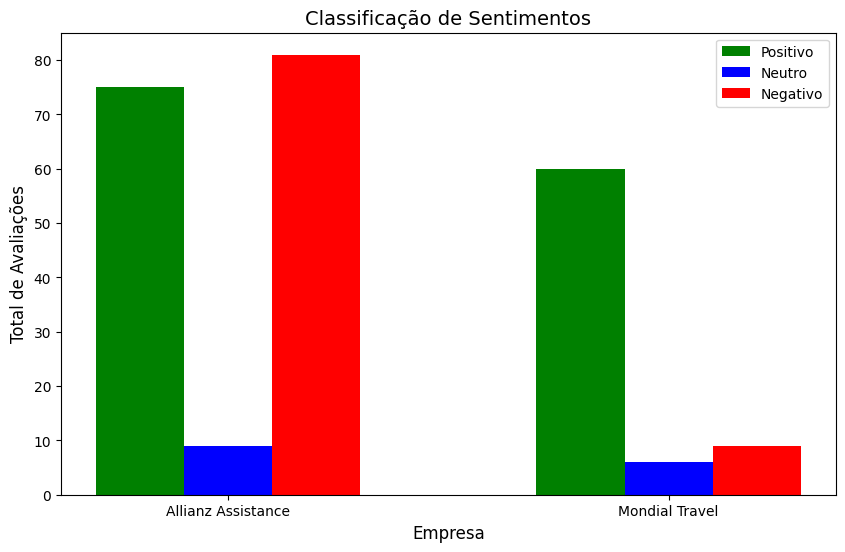

In [ ]:
# Contagem de avaliações por empresa e classificação
df['classificacao'] = df['classificacao'].str.lower()

contagem_avaliacoes = df.groupby(['empresa', 'classificacao']).size().unstack(fill_value=0)

# Criar gráfico de barras clusterizado
fig, ax = plt.subplots(figsize=(10, 6))

# Largura das barras
bar_width = 0.2

# Posições das barras
r1 = range(len(contagem_avaliacoes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Criar barras para cada classificação
ax.bar(r1, contagem_avaliacoes['positivo'], color='green', width=bar_width, label='Positivo')
ax.bar(r2, contagem_avaliacoes['neutro'], color='blue', width=bar_width, label='Neutro')
ax.bar(r3, contagem_avaliacoes['negativo'], color='red', width=bar_width, label='Negativo')

# Configurar o gráfico
ax.set_xlabel('Empresa', fontsize=12)
ax.set_ylabel('Total de Avaliações', fontsize=12)
ax.set_title('Classificação de Sentimentos', fontsize=14)
ax.set_xticks([r + bar_width for r in range(len(contagem_avaliacoes))])
ax.set_xticklabels(contagem_avaliacoes.index)
ax.legend()

plt.show()

##### **Wordclouds**

###### Allianz - **Wordcloud** Avaliações **Positivas**

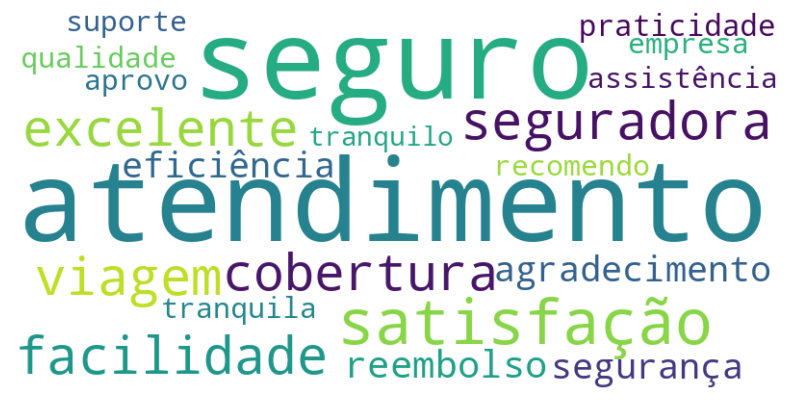

In [ ]:
df_allianz_negativo = df[(df['empresa'] == 'Allianz Assistance') & (df['classificacao'] == 'positivo')]
texto_allianz_negativo = ' '.join(df_allianz_negativo['palavra_resumo'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_allianz_negativo)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###### Allianz - **Wordcloud** Avaliações **Negativas**

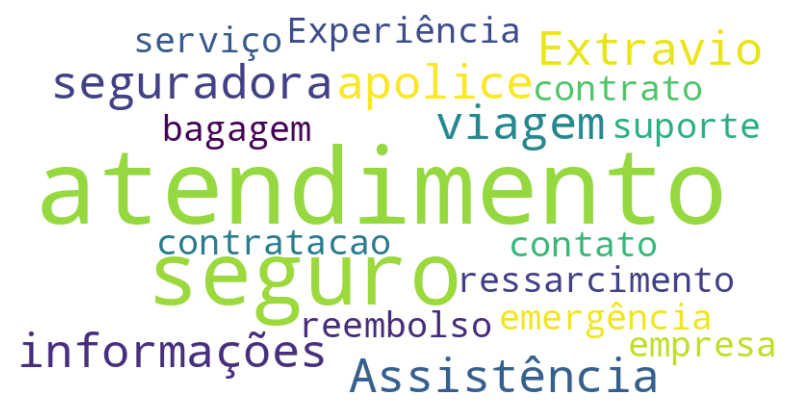

In [ ]:
df_allianz_negativo = df[(df['empresa'] == 'Allianz Assistance') & (df['classificacao'] == 'negativo')]
texto_allianz_negativo = ' '.join(df_allianz_negativo['palavra_resumo'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_allianz_negativo)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###### Mondial - **Wordcloud** Avaliações **Positivas**

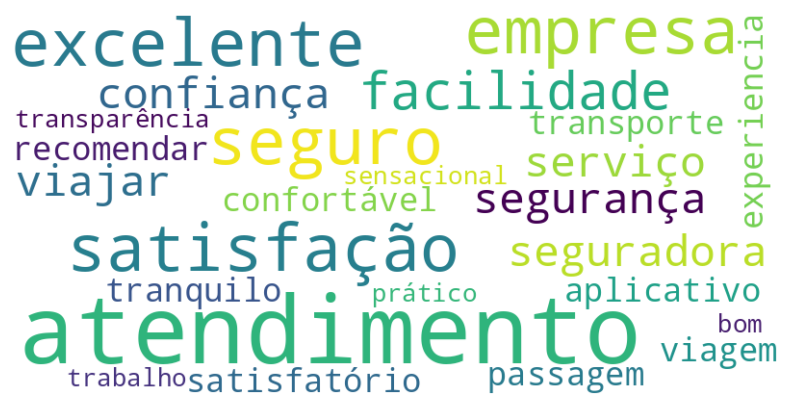

In [ ]:
df_allianz_negativo = df[(df['empresa'] == 'Mondial Travel') & (df['classificacao'] == 'positivo')]
texto_allianz_negativo = ' '.join(df_allianz_negativo['palavra_resumo'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_allianz_negativo)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###### Mondial - **Wordcloud** Avaliações **Negativas**

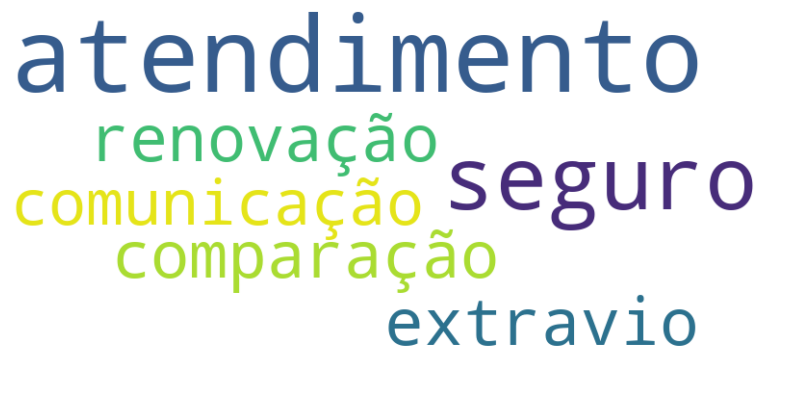

In [ ]:
df_allianz_negativo = df[(df['empresa'] == 'Mondial Travel') & (df['classificacao'] == 'negativo')]
texto_allianz_negativo = ' '.join(df_allianz_negativo['palavra_resumo'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_allianz_negativo)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### Análise **Temporal** da Classificação de Sentimento

######  Allianz Assistance

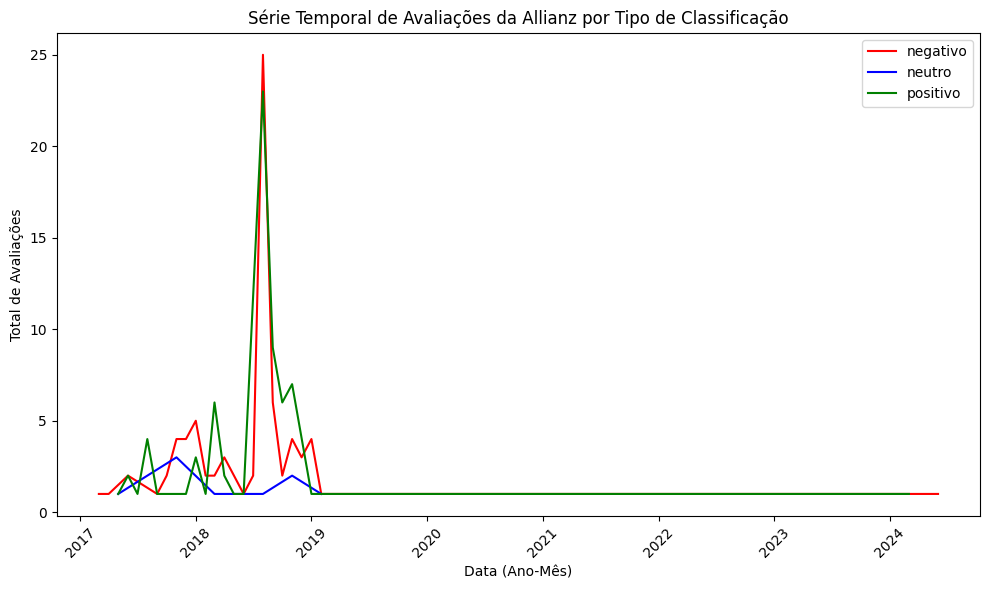

In [ ]:
df['data_avaliacao'] = pd.to_datetime(df['data_avaliacao'], format='%d/%m/%Y')
df['ano_mes'] = df['data_avaliacao'].dt.strftime('%Y-%m')

df_allianz = df[df['empresa'] == 'Allianz Assistance']
df_grouped = df_allianz.groupby(['ano_mes', 'classificacao']).size().reset_index(name='total')

df_grouped['ano_mes'] = pd.to_datetime(df_grouped['ano_mes'], format='%Y-%m')


fig, ax = plt.subplots(figsize=(10, 6))
cores = {'positivo': 'green', 'negativo': 'red', 'neutro': 'blue'}

# Plotar cada classificação como uma linha separada
for classificacao in df_grouped['classificacao'].unique():
    df_classificacao = df_grouped[df_grouped['classificacao'] == classificacao]
    ax.plot(df_classificacao['ano_mes'], df_classificacao['total'], label=classificacao, color=cores[classificacao])

ax.set_xlabel('Data (Ano-Mês)')
ax.set_ylabel('Total de Avaliações')
ax.set_title('Série Temporal de Avaliações da Allianz por Tipo de Classificação')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###### Mondial Travel

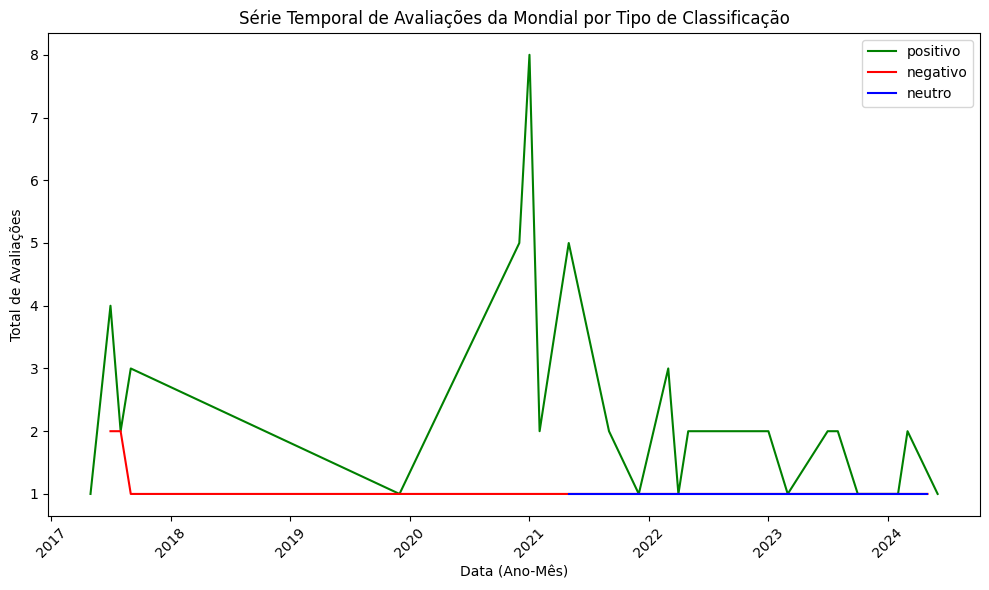

In [ ]:
df['data_avaliacao'] = pd.to_datetime(df['data_avaliacao'], format='%d/%m/%Y')
df['ano_mes'] = df['data_avaliacao'].dt.strftime('%Y-%m')

df_allianz = df[df['empresa'] == 'Mondial Travel']
df_grouped = df_allianz.groupby(['ano_mes', 'classificacao']).size().reset_index(name='total')

df_grouped['ano_mes'] = pd.to_datetime(df_grouped['ano_mes'], format='%Y-%m')

fig, ax = plt.subplots(figsize=(10, 6))
cores = {'positivo': 'green', 'negativo': 'red', 'neutro': 'blue'}

# Plotar cada classificação como uma linha separada
for classificacao in df_grouped['classificacao'].unique():
    df_classificacao = df_grouped[df_grouped['classificacao'] == classificacao]
    ax.plot(df_classificacao['ano_mes'], df_classificacao['total'], label=classificacao, color=cores[classificacao])

ax.set_xlabel('Data (Ano-Mês)')
ax.set_ylabel('Total de Avaliações')
ax.set_title('Série Temporal de Avaliações da Mondial por Tipo de Classificação')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **Ranking** de **Palavras Resumo** para as avaliações - Allianz Assistance

###### Avaliações **Positivas** - Allianz Assistance

In [ ]:
# Filtrando avaliações positivas da Allianz
df_allianz_positivo = df[(df['empresa'] == 'Allianz Assistance') & (df['classificacao'] == 'positivo')]

# Contando a frequência das palavras nas avaliações positivas
word_counts = {}
for _, row in df_allianz_positivo.iterrows():
    words = row['palavra_resumo'].split()
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Ordenando as palavras pela frequência
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

# Criando o ranking em formato de tabela (Top 5)
ranking_table = pd.DataFrame(sorted_word_counts[:5], columns=['Palavra Resumo', 'Frequência'])
ranking_table.index = ranking_table.index + 1  # Adicionando 1 para iniciar o ranking do 1

ranking_table.head(50)

,Palavra Resumo,Frequência
1,atendimento,25
2,seguro,24
3,satisfação,3
4,seguradora,2
5,facilidade,2


###### Avaliações **Negativas** - Allianz Assistance

In [ ]:
# Filtrando avaliações positivas da Allianz
df_allianz_positivo = df[(df['empresa'] == 'Allianz Assistance') & (df['classificacao'] == 'negativo')]

# Contando a frequência das palavras nas avaliações positivas
word_counts = {}
for _, row in df_allianz_positivo.iterrows():
    words = row['palavra_resumo'].split()
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Ordenando as palavras pela frequência
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

# Criando o ranking em formato de tabela (Top 5)
ranking_table = pd.DataFrame(sorted_word_counts[:10], columns=['Palavra Resumo', 'Frequência'])
ranking_table.index = ranking_table.index + 1  # Adicionando 1 para iniciar o ranking do 1

ranking_table.head(50)

,Palavra Resumo,Frequência
1,atendimento,34
2,seguro,23
3,apolice,2
4,Atendimento,2
5,informações,2
6,viagem,2
7,Assistência,1
8,serviço,1
9,ressarcimento,1
10,emergência,1


##### **Ranking** de **Palavras Resumo** para as avaliações -  Mondial Travel

###### Avaliações Positivas -  Mondial Travel

In [ ]:
df_mondial_positivo = df[(df['empresa'] == 'Mondial Travel') & (df['classificacao'] == 'positivo')]

# Contando a frequência das palavras nas avaliações positivas
word_counts = {}
for _, row in df_mondial_positivo.iterrows():
    words = row['palavra_resumo'].split()
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Ordenando as palavras pela frequência
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

# Criando o ranking em formato de tabela (Top 5)
ranking_table = pd.DataFrame(sorted_word_counts[:5], columns=['Palavra Resumo', 'Frequência'])
ranking_table.index = ranking_table.index + 1  # Adicionando 1 para iniciar o ranking do 1

ranking_table.head(50)

,Palavra Resumo,Frequência
1,atendimento,13
2,seguro,5
3,satisfação,5
4,empresa,5
5,excelente,5


###### Avaliações Negativas -  Mondial Travel

In [ ]:
df_mondial_negativo = df[(df['empresa'] == 'Mondial Travel') & (df['classificacao'] == 'negativo')]

# Contando a frequência das palavras nas avaliações positivas
word_counts = {}
for _, row in df_mondial_negativo.iterrows():
    words = row['palavra_resumo'].split()
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Ordenando as palavras pela frequência
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

# Criando o ranking em formato de tabela (Top 5)
ranking_table = pd.DataFrame(sorted_word_counts[:5], columns=['Palavra Resumo', 'Frequência'])
ranking_table.index = ranking_table.index + 1  # Adicionando 1 para iniciar o ranking do 1

ranking_table.head(50)

,Palavra Resumo,Frequência
1,atendimento,3
2,seguro,2
3,extravio,1
4,comparação,1
5,renovação,1


### Testes

#### Experimentos

In [ ]:
'''
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# TEXT BLOB
for avaliacao in all_reviews:
  doc = nlp(avaliacao['avaliacao'])
  blob = TextBlob(doc.text)
  polaridade = blob.sentiment.polarity
  # Normalizar a polaridade para a escala de 1 a 5
  pontuacao = (polaridade + 1) * 2.5
  print(f"Avaliação: {avaliacao['avaliacao']}")
  print(f"Polaridade: {polaridade:.2f}")
  print(f"Pontuação (1-5): {pontuacao:.2f}\n")


from transformers import pipeline
# Carregar o modelo BERTimbau para análise de sentimento
classifier = pipeline("sentiment-analysis", model="neuralmind/bert-base-portuguese-cased")
for avaliacao in avaliacoes_prontas:
  resultado = classifier(avaliacao)
  print(resultado)
'''

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'LABEL_0', 'score': 0.5135776996612549}]
[{'label': 'LABEL_0', 'score': 0.5357905030250549}]
[{'label': 'LABEL_0', 'score': 0.5191795825958252}]
[{'label': 'LABEL_0', 'score': 0.5191436409950256}]
[{'label': 'LABEL_0', 'score': 0.5157914161682129}]
[{'label': 'LABEL_0', 'score': 0.5333523154258728}]
[{'label': 'LABEL_0', 'score': 0.5347655415534973}]
[{'label': 'LABEL_0', 'score': 0.5048558712005615}]
[{'label': 'LABEL_0', 'score': 0.5384640693664551}]
[{'label': 'LABEL_0', 'score': 0.5220620632171631}]
[{'label': 'LABEL_0', 'score': 0.5148895978927612}]
[{'label': 'LABEL_0', 'score': 0.5367481112480164}]
[{'label': 'LABEL_0', 'score': 0.5111161470413208}]
[{'label': 'LABEL_0', 'score': 0.5231316685676575}]
[{'label': 'LABEL_0', 'score': 0.5455567836761475}]
[{'label': 'LABEL_0', 'score': 0.5388253331184387}]
[{'label': 'LABEL_0', 'score': 0.522203803062439}]
[{'label': 'LABEL_0', 'score': 0.5262128114700317}]
[{'label': 'LABEL_0', 'score': 0.5219993591308594}]
[{'label': 'L

#### POC Spacy

In [ ]:
'''
# Carregar o modelo de português
nlp = spacy.load("pt_core_news_sm")

# Processar um texto
doc = nlp("Em viagem a Cusco no Peru precisei da emergência médica a qual solicitei via aplicativo Travel Smart e fui muito bem atendida em 30 minutos fui atendida no hotel onde estava hospedada e após ter sida avaliada por uma médica fui removida por uma ambulância para um hospital onde fui prontamente internada e medicada juntamente com acompanhante. Só tenho que agradecer a todos pelo bom atendimento.Obrigada, recomendo.")

# Criar listas para armazenar os dados
tokens = []
pos = []
dep = []

# Preencher as listas com os dados dos tokens
for token in doc:
    tokens.append(token.text)
    pos.append(token.pos_)
    dep.append(token.dep_)

# Criar um DataFrame com os dados
df = pd.DataFrame({
    'Token': tokens,
    'POS': pos,
    'Dependência': dep
})

# Exibir o DataFrame em um csv
df.to_csv("pocSpacy.csv", index=False)